In [30]:
import os
import glob
from dotenv import load_dotenv
from langchain.prompts import PromptTemplate
from langchain.schema.runnable import RunnablePassthrough
from langchain.schema.output_parser import StrOutputParser
from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAIEmbeddings
from langchain.vectorstores import FAISS
from langchain.document_loaders import TextLoader
# Import the visualization function from your module
from mag_visualizer import visualize_from_file

FAISS_INDEX_PATH = "faiss_mag_index"
GENERATED_MAG_DIR = "generated_mag"

class MagicLayoutGenerator:
    """
    RAG-based generator with a refined prompt for adapting layouts.
    """
    def __init__(self, mag_files_directory: str):
        print("🚀 Initializing MagicLayoutGenerator...")
        load_dotenv()
        api_key = os.getenv("GOOGLE_API_KEY")
        if not api_key: raise ValueError("🔴 GOOGLE_API_KEY not found.")

        self.llm = ChatGoogleGenerativeAI(model="gemini-2.5-pro", google_api_key=api_key, temperature=0.25)
        self.embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001", google_api_key=api_key)
        self._load_or_create_vector_store(mag_files_directory)

        # --- New, Refined "Zero-Shot" Prompt ---
        # This prompt focuses on instructing the model how to think and adapt.
        mag_prompt_template = """
You are an expert physical design engineer. Your task is to generate a new, complete, and syntactically correct Magic layout file (.mag format) by adapting an existing layout.

Follow these steps carefully:
1.  Analyze the user's 'QUESTION' to understand the target cell name and function (e.g., 'MY_NAND2', '2-input NAND gate').
2.  Analyze the provided 'CONTEXT'. The 'CONTEXT' is the .mag file of a similar, existing cell. Understand its structure, layers, and coordinate system.
3.  Modify the 'CONTEXT' to create the new design. For example, if the CONTEXT is an AND gate and the QUESTION is for a NAND gate, you must modify the output stage to add the necessary inversion. Change the labels and cell name as requested.
4.  Ensure the final output is ONLY the complete .mag file content. It must start with 'magic' and end with '<< end >>'. Do not add any other text, comments, or explanations.

CONTEXT:
{context}

QUESTION:
{question}

ANSWER (.mag File Content):
"""
        prompt = PromptTemplate.from_template(mag_prompt_template)
        self.chain = ({"context": self.retriever, "question": RunnablePassthrough()} | prompt | self.llm | StrOutputParser())
        print("\n🎉 MagicLayoutGenerator initialized successfully!")

    def _load_or_create_vector_store(self, path: str):
        if os.path.exists(FAISS_INDEX_PATH):
            print(f"✅ Loading existing vector store from '{FAISS_INDEX_PATH}'...")
            self.vector_store = FAISS.load_local(FAISS_INDEX_PATH, self.embeddings, allow_dangerous_deserialization=True)
        else:
            print(f"🔍 Creating new vector store...")
            mag_files = glob.glob(os.path.join(path, '**', '*.mag'), recursive=True)
            if not mag_files: raise FileNotFoundError(f"🔴 No .mag files found in '{path}'.")
            documents = [TextLoader(file_path).load()[0] for file_path in mag_files]
            self.vector_store = FAISS.from_documents(documents, self.embeddings)
            self.vector_store.save_local(FAISS_INDEX_PATH)
            print(f"✅ New vector store saved to '{FAISS_INDEX_PATH}'.")
        self.retriever = self.vector_store.as_retriever()

    def generate_and_save(self, query: str, filename: str):
        """
        Generates .mag content, saves it, and reveals which context was used.
        """
        print(f"\n💡 Generating layout for: '{query}'")

        # RAG retrieval debugging
        retrieved_docs = self.retriever.get_relevant_documents(query)
        if retrieved_docs:
            source_file = os.path.basename(retrieved_docs[0].metadata.get('source', 'Unknown'))
            print(f"🔍 RAG system retrieved '{source_file}' as context.")
        else:
            print("🟡 Warning: RAG system did not retrieve any context.")

        mag_content = self.chain.invoke(query)
        os.makedirs(GENERATED_MAG_DIR, exist_ok=True)
        file_path = os.path.join(GENERATED_MAG_DIR, filename)
        with open(file_path, "w") as f:
            f.write(mag_content)
        print(f"✅ Layout saved to '{file_path}'")
        return file_path

In [32]:
# Path to the directory containing your .mag files
MAG_FILES_PATH = '../std_cells_datasets/'

# Initialize the generator. This is done only once.
layout_generator = MagicLayoutGenerator(mag_files_directory=MAG_FILES_PATH)

🚀 Initializing MagicLayoutGenerator...
🔍 Creating new vector store...
✅ New vector store saved to 'faiss_mag_index'.

🎉 MagicLayoutGenerator initialized successfully!


In [37]:
# Define the generation query and the desired filename
query = "a compact 2-input NAND gate layout for sky130A tech named 'MY_NAND2'"
filename = "my_nand_gate2.mag"

# Generate the layout and save the file path
saved_file_path = layout_generator.generate_and_save(query, filename)


💡 Generating layout for: 'a compact 2-input NAND gate layout for sky130A tech named 'MY_NAND2''
🔍 RAG system retrieved 'and_common_3.mag' as context.


KeyboardInterrupt: 

File was generated at: generated_mag/my_nand_gate2.mag
📊 Visualizing layout from: generated_mag/my_nand_gate2.mag


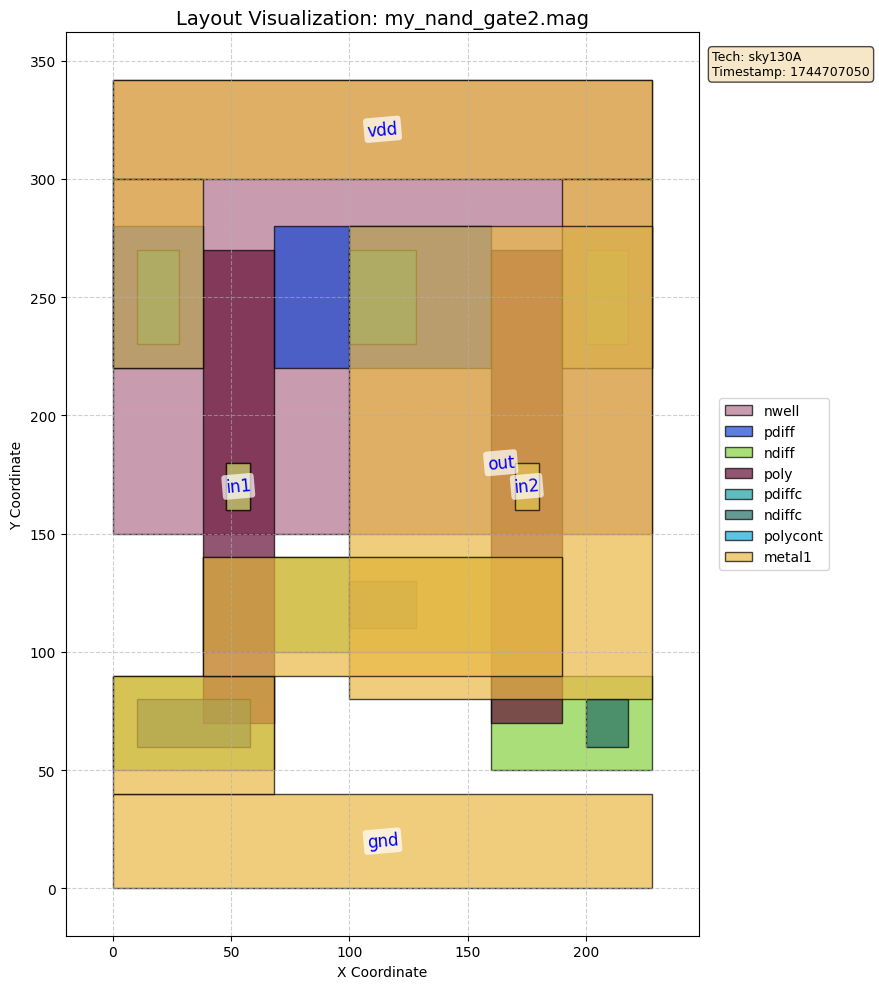

In [35]:
print(f"File was generated at: {saved_file_path}")

visualize_from_file("generated_mag/my_nand_gate2.mag")

In [33]:
# Define the generation query and the desired filename
query = "an INVERTER gate layout for sky130A tech named 'INV_1'"
filename = "my_inv.mag"

# Generate the layout and save the file path
saved_file_path = layout_generator.generate_and_save(query, filename)


💡 Generating layout for: 'an INVERTER gate layout for sky130A tech named 'INV_1''
🔍 RAG system retrieved 'inv2.mag' as context.
✅ Layout saved to 'generated_mag/my_inv.mag'


File was generated at: generated_mag/my_nand_gate2.mag
📊 Visualizing layout from: generated_mag/my_inv.mag


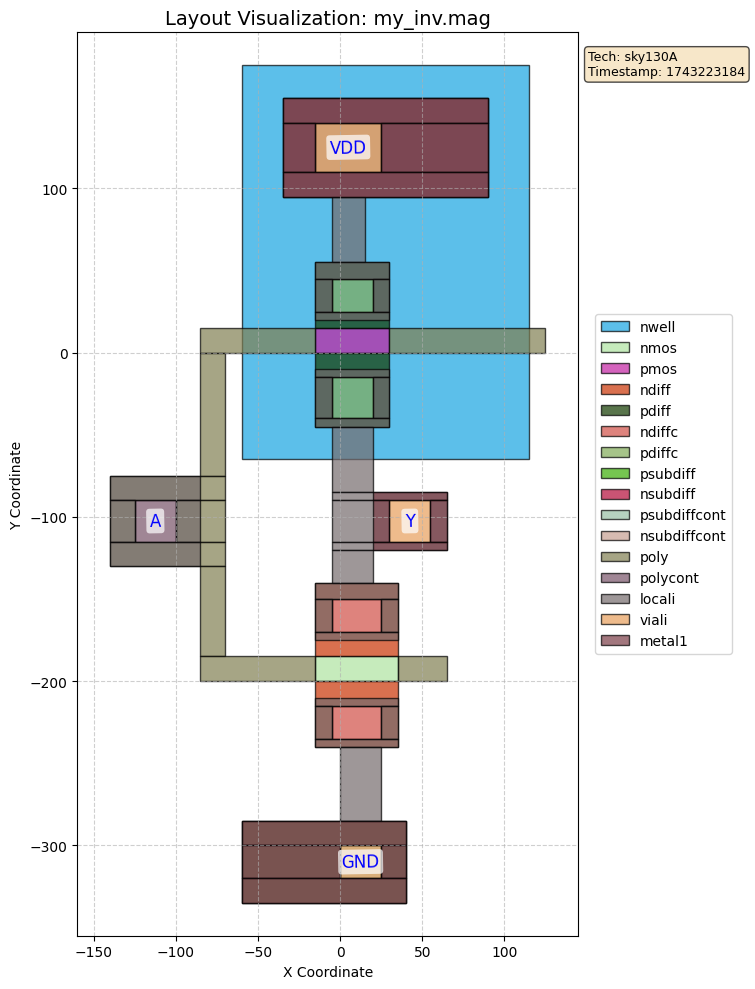

In [36]:
print(f"File was generated at: {saved_file_path}")

visualize_from_file("generated_mag/my_inv.mag")

In [17]:
import os
import glob
import re
from dotenv import load_dotenv
from langchain.prompts import PromptTemplate
from langchain.schema.runnable import RunnablePassthrough
from langchain.schema.output_parser import StrOutputParser
from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAIEmbeddings
from langchain.vectorstores import FAISS
from langchain.docstore.document import Document
# Import the visualization function from your module
from mag_visualizer import visualize_from_file

FAISS_INDEX_PATH = "faiss_mag_index"
GENERATED_MAG_DIR = "generated_mag"

class MagicLayoutGenerator:
    """
    Corrected RAG-based generator that properly separates retrieval and generation
    to resolve the embedding error.
    """
    def __init__(self, mag_files_directory: str):
        print("🚀 Initializing MagicLayoutGenerator...")
        load_dotenv()
        api_key = os.getenv("GOOGLE_API_KEY")
        if not api_key: raise ValueError("🔴 GOOGLE_API_KEY not found.")

        self.llm = ChatGoogleGenerativeAI(model="gemini-2.5-pro", google_api_key=api_key, temperature=0.25)
        self.embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001", google_api_key=api_key)
        self._load_or_create_vector_store(mag_files_directory)

        # --- Corrected, Simplified Prompt and Chain ---
        # The chain no longer includes the retriever. It only formats the prompt.
        mag_prompt_template = """
You are an expert physical design engineer. Your task is to generate a new, complete, and syntactically correct Magic layout file (.mag format) by adapting an existing layout.

Follow these steps carefully:
1.  Analyze the user's 'QUESTION' to understand the target cell name and function.
2.  Analyze the provided 'CONTEXT'. The 'CONTEXT' is the .mag file of a similar, existing cell. Understand its structure and layers.
3.  Modify the 'CONTEXT' to create the new design as requested in the 'QUESTION'. Change labels and the cell name as needed.
4.  Ensure the final output is ONLY the complete .mag file content. It must start with 'magic' and end with '<< end >>'. Do not add any other text or explanations.

CONTEXT:
{context}

QUESTION:
{question}

ANSWER (.mag File Content):
"""
        prompt = PromptTemplate.from_template(mag_prompt_template)
        # The chain now simply takes the context and question and passes them to the LLM.
        self.chain = prompt | self.llm | StrOutputParser()
        print("\n🎉 MagicLayoutGenerator initialized successfully!")

    def _preprocess_mag_file(self, file_path: str):
        """
        Reads a .mag file and prepends a description if a special comment is found.
        """
        with open(file_path, 'r') as f:
            content = f.read()
        match = re.search(r"#\s*THIS IS A?\s*(.*)", content, re.IGNORECASE)
        description = ""
        if match:
            gate_type = match.group(1).strip()
            description = f"This file contains the Magic layout for a {gate_type}. "
        return Document(page_content=description + content, metadata={"source": file_path})

    def _load_or_create_vector_store(self, path: str):
        if os.path.exists(FAISS_INDEX_PATH):
            print(f"✅ Loading existing vector store from '{FAISS_INDEX_PATH}'...")
            self.vector_store = FAISS.load_local(FAISS_INDEX_PATH, self.embeddings, allow_dangerous_deserialization=True)
        else:
            print(f"🔍 Creating new vector store with preprocessing...")
            mag_files = glob.glob(os.path.join(path, '**', '*.mag'), recursive=True)
            if not mag_files: raise FileNotFoundError(f"🔴 No .mag files found in '{path}'.")
            documents = [self._preprocess_mag_file(file_path) for file_path in mag_files]
            self.vector_store = FAISS.from_documents(documents, self.embeddings)
            self.vector_store.save_local(FAISS_INDEX_PATH)
            print(f"✅ New vector store saved to '{FAISS_INDEX_PATH}'.")
        self.retriever = self.vector_store.as_retriever(search_kwargs={"k": 3})

    def generate_and_save(self, query: str, filename: str):
        """
        Generates .mag content by manually retrieving context and then calling the chain.
        """
        print(f"\n💡 Generating layout for: '{query}'")

        # Step 1: Manually retrieve the documents.
        retrieved_docs = self.retriever.get_relevant_documents(query)
        
        if retrieved_docs:
            print(f"🔍 RAG system retrieved {len(retrieved_docs)} contexts:")
            # Step 2: Format the retrieved documents into a single context string.
            context_str = ""
            for i, doc in enumerate(retrieved_docs):
                source_file = os.path.basename(doc.metadata.get('source', 'Unknown'))
                print(f"  - Context {i+1}: '{source_file}'")
                context_str += f"--- CONTEXT {i+1} ({source_file}) ---\n{doc.page_content}\n\n"
        else:
            print("🟡 Warning: RAG system did not retrieve any context.")
            context_str = "No context found."
        
        # Step 3: Invoke the simplified chain with the prepared context and question.
        mag_content = self.chain.invoke({"context": context_str, "question": query})

        os.makedirs(GENERATED_MAG_DIR, exist_ok=True)
        file_path = os.path.join(GENERATED_MAG_DIR, filename)
        with open(file_path, "w") as f:
            f.write(mag_content)
        print(f"✅ Layout saved to '{file_path}'")
        return file_path

ImportError: cannot import name 'visualize_from_file' from 'mag_visualizer' (/home/irman/LLM_for_Chip_Design_Automation/std_cells_codes/mag_visualizer.py)

In [48]:
# Path to the directory containing your .mag files
MAG_FILES_PATH = '../std_cells_datasets/'

# Initialize the generator.
# If you updated your .mag files with comments, delete the 'faiss_mag_index' folder to force a rebuild.
layout_generator = MagicLayoutGenerator(mag_files_directory=MAG_FILES_PATH)

🚀 Initializing MagicLayoutGenerator...
✅ Loading existing vector store from 'faiss_mag_index'...

🎉 MagicLayoutGenerator initialized successfully!


In [49]:
# Define the generation query and the desired filename
query = "an INVERTER gate layout for sky130A tech named 'INV_1'"
filename = "my_inv.mag"

# Generate the layout and save the file path
saved_file_path = layout_generator.generate_and_save(query, filename)


💡 Generating layout for: 'an INVERTER gate layout for sky130A tech named 'INV_1''
🔍 RAG system retrieved 3 contexts:
  - Context 1: 'inverter.mag'
  - Context 2: 'inv2.mag'
  - Context 3: 'inverter_common.mag'
✅ Layout saved to 'generated_mag/my_inv.mag'


File was generated at: generated_mag/my_inv.mag
📊 Visualizing layout from: generated_mag/my_inv.mag


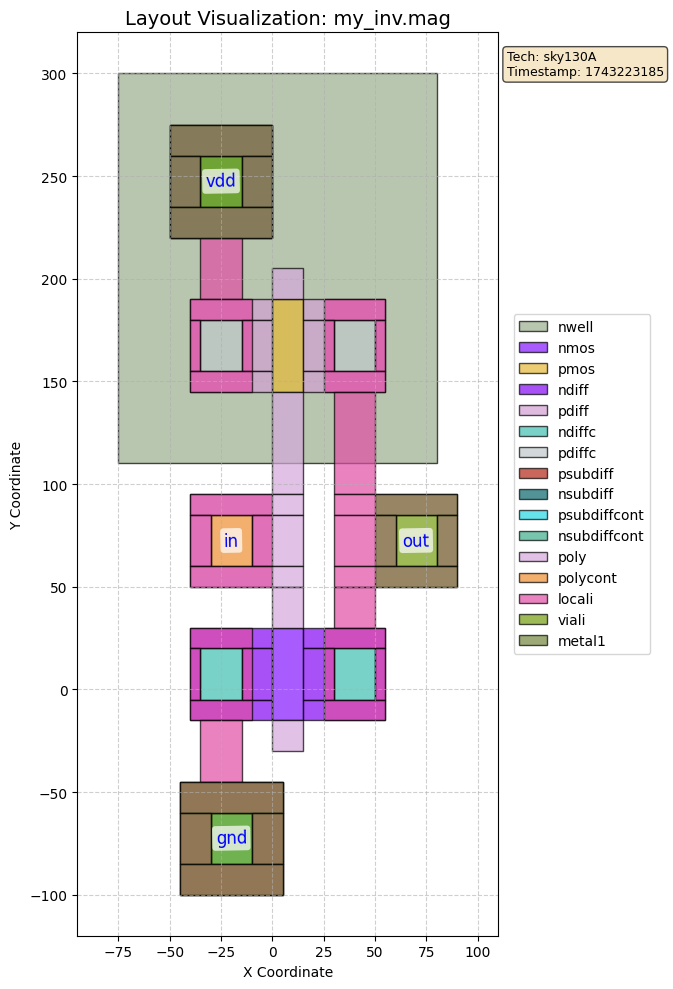

In [50]:
print(f"File was generated at: {saved_file_path}")

visualize_from_file("generated_mag/my_inv.mag")

📊 Visualizing layout from: ../std_cells_datasets/inv2.mag


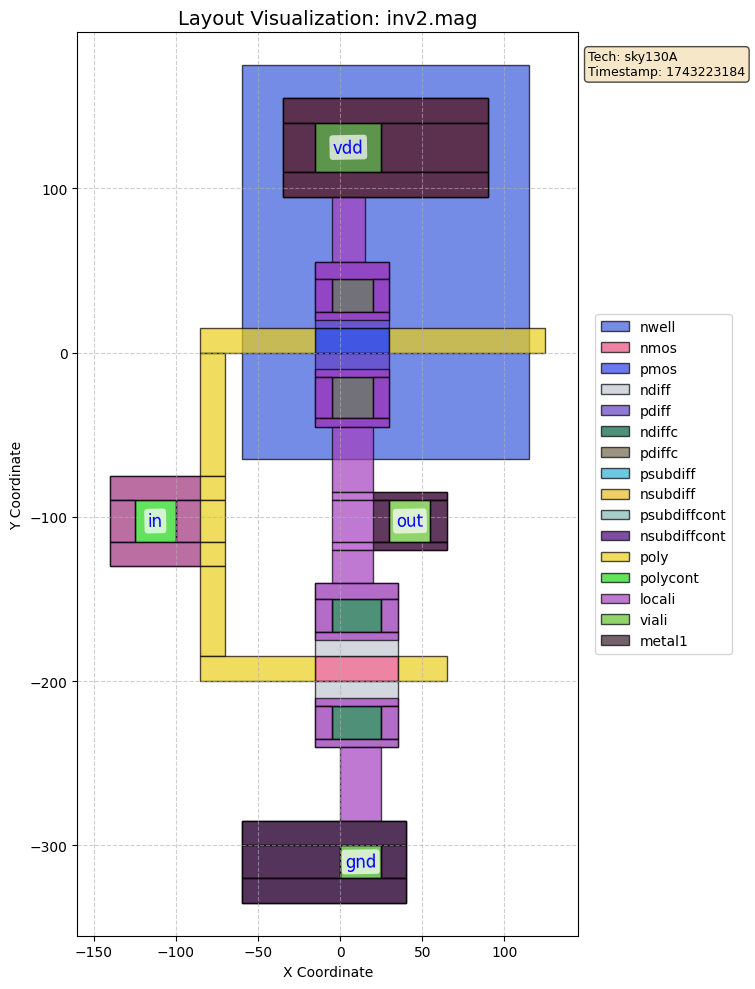

In [56]:
visualize_from_file("../std_cells_datasets/inv2.mag")

In [51]:
# Define the generation query and the desired filename
query = "a compact 2-input NAND gate layout for sky130A tech named 'MY_NAND2'"
filename = "my_nand_gate.mag"

# Generate the layout and save the file path
saved_file_path = layout_generator.generate_and_save(query, filename)


💡 Generating layout for: 'a compact 2-input NAND gate layout for sky130A tech named 'MY_NAND2''
🔍 RAG system retrieved 3 contexts:
  - Context 1: 'and_common_3.mag'
  - Context 2: 'nand.mag'
  - Context 3: 'inv2.mag'
✅ Layout saved to 'generated_mag/my_nand_gate.mag'


File was generated at: generated_mag/my_nand_gate.mag
📊 Visualizing layout from: generated_mag/my_nand_gate.mag


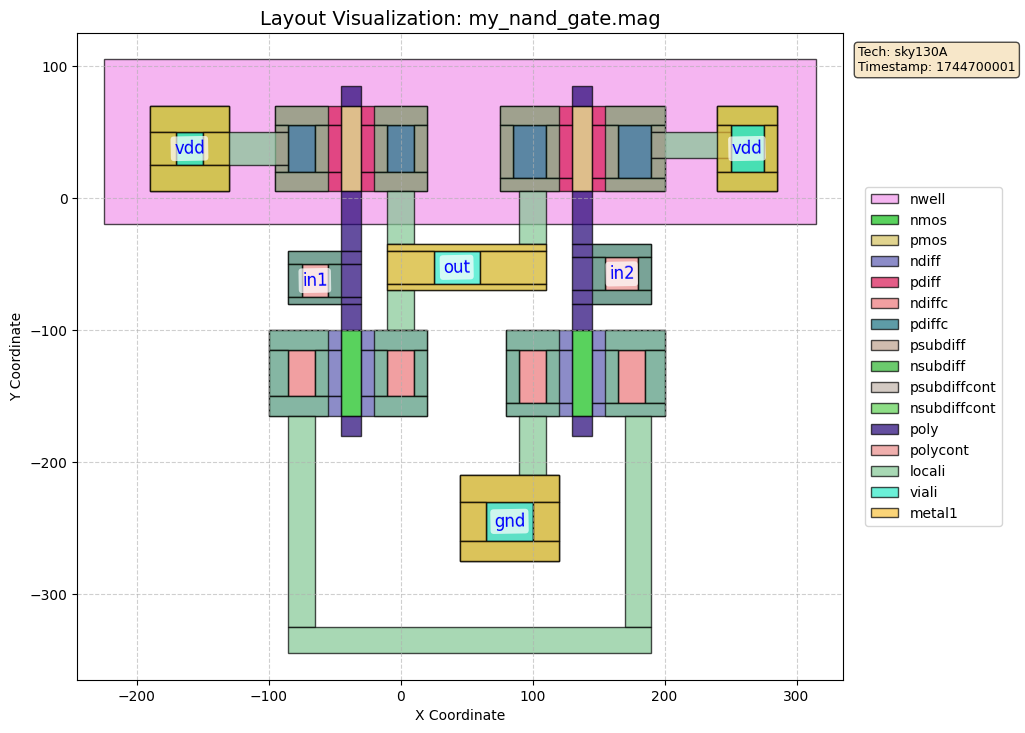

In [52]:
print(f"File was generated at: {saved_file_path}")

visualize_from_file("generated_mag/my_nand_gate.mag")

📊 Visualizing layout from: ../std_cells_datasets/nand.mag


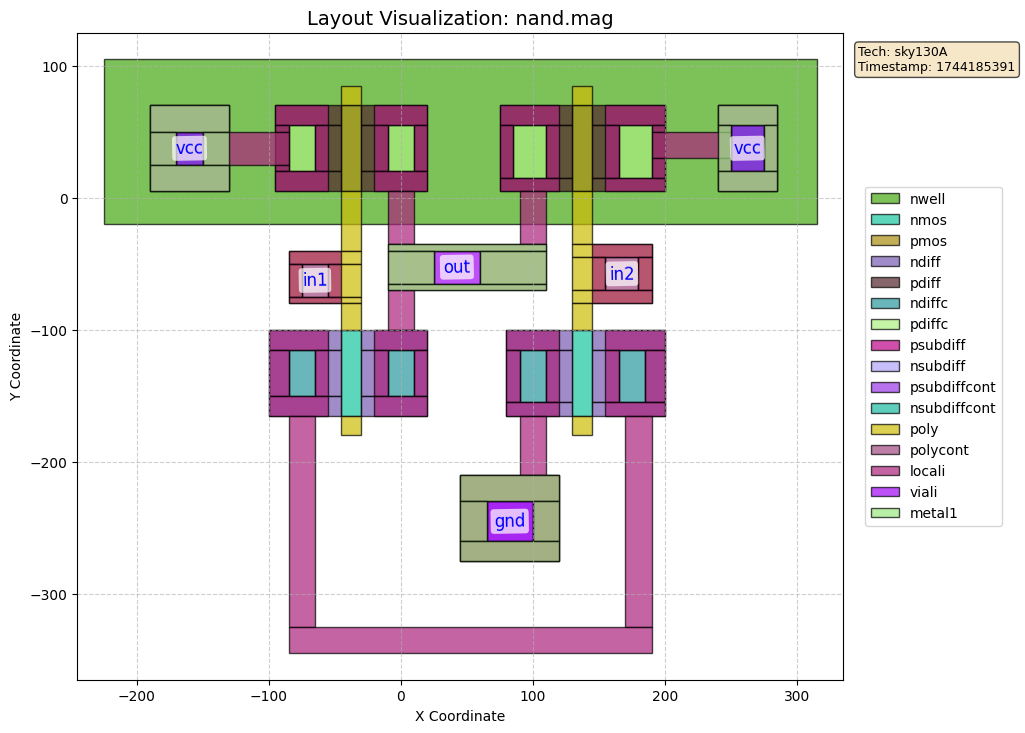

In [57]:
visualize_from_file("../std_cells_datasets/nand.mag")

In [58]:
# Define the generation query and the desired filename
query = "a compact 2-input MUX gate layout for sky130A tech named 'MY_MUX2'"
filename = "my_mux_gate.mag"

# Generate the layout and save the file path
saved_file_path = layout_generator.generate_and_save(query, filename)


💡 Generating layout for: 'a compact 2-input MUX gate layout for sky130A tech named 'MY_MUX2''
🔍 RAG system retrieved 3 contexts:
  - Context 1: 'mux_latch.mag'
  - Context 2: 'inv2.mag'
  - Context 3: 'inverter_common.mag'
✅ Layout saved to 'generated_mag/my_mux_gate.mag'


📊 Visualizing layout from: generated_mag/my_mux_gate.mag


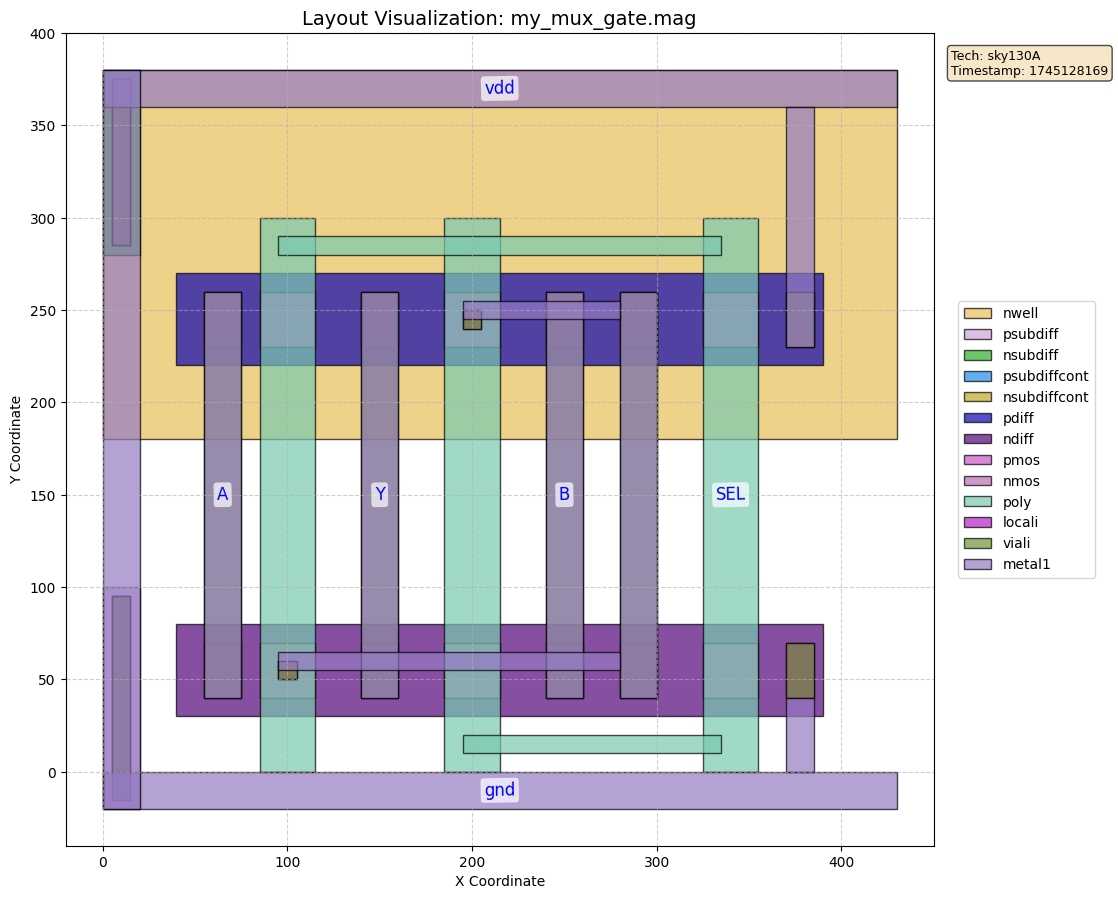

In [59]:
visualize_from_file("generated_mag/my_mux_gate.mag")

📊 Visualizing layout from: ../std_cells_datasets/mux_common_4.mag


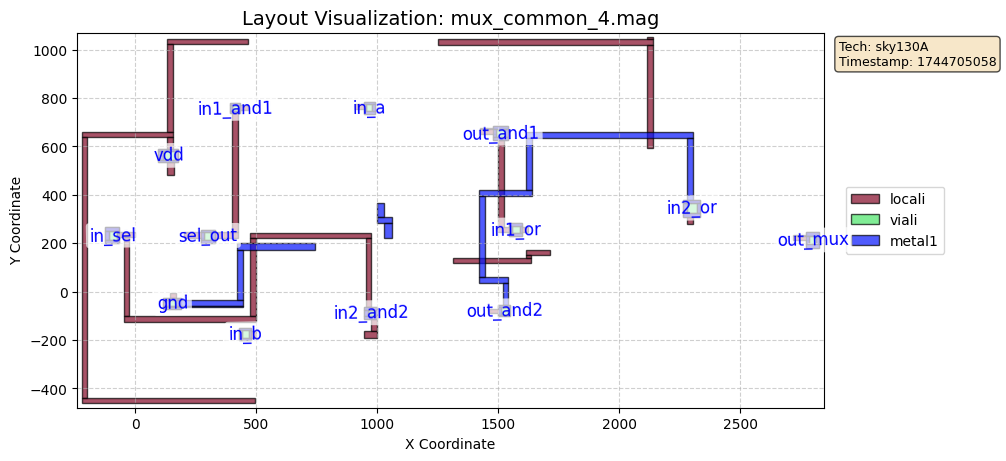

In [61]:
visualize_from_file("../std_cells_datasets/mux_common_4.mag")

In [2]:
import os
import glob
import re
import json
from dotenv import load_dotenv
from langchain.prompts import PromptTemplate
# CORRECTED IMPORT: JsonOutputParser is in langchain_core, not langchain.schema
from langchain_core.output_parsers import StrOutputParser, JsonOutputParser
from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAIEmbeddings
from langchain.vectorstores import FAISS
from langchain.docstore.document import Document
# Import the visualization function from your module
from mag_visualizer import visualize_layout

FAISS_INDEX_PATH = "faiss_mag_index"
GENERATED_MAG_DIR = "generated_mag"

class MagicLayoutGenerator:
    """
    An advanced RAG generator using a "Plan-and-Execute" strategy.
    1. Plan: Deconstructs the request into necessary components.
    2. Execute: Retrieves each component and synthesizes them into a final layout.
    """
    def __init__(self, mag_files_directory: str):
        print("🚀 Initializing Advanced MagicLayoutGenerator...")
        load_dotenv()
        api_key = os.getenv("GOOGLE_API_KEY")
        if not api_key: raise ValueError("🔴 GOOGLE_API_KEY not found.")

        # Shared LLM for both planning and synthesis
        self.llm = ChatGoogleGenerativeAI(model="gemini-2.5-pro", google_api_key=api_key, temperature=0.2)
        self.embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001", google_api_key=api_key)
        self._load_or_create_vector_store(mag_files_directory)

        # --- 1. The Planner Chain ---
        planner_prompt = PromptTemplate.from_template(
            """You are a digital logic planner. Based on the user's request, determine the fundamental logic gates required to build it.
            Respond with ONLY a JSON object containing a single key "components", which is a list of strings.
            For example, for 'a 2-input AND gate', you would respond with {{"components": ["2-input NAND gate", "inverter"]}}.
            For 'a 2-input MUX', you would respond with {{"components": ["2-input AND gate", "2-input AND gate", "inverter", "2-input OR gate"]}}.
            User Request: {query}"""
        )
        self.planner_chain = planner_prompt | self.llm | JsonOutputParser()

        # --- 2. The Synthesis Chain ---
        synthesis_prompt_template = """
You are an expert physical design engineer and layout architect using the Magic VLSI tool.
Your task is to create a new, single .mag layout by intelligently combining several component layouts provided in the 'CONTEXTS' section.

Follow these critical steps:
1.  **Goal Analysis**: First, understand the user's high-level 'QUESTION'.
2.  **Component Analysis**: Review each numbered 'CONTEXT' provided. Each context is a complete .mag file for a necessary component.
3.  **Placement & Coordinate Calculation**: This is the most important step. You must place the component cells next to each other without overlap. This requires recalculating the coordinates of ALL rectangles from subsequent context files by shifting their X or Y coordinates.
4.  **Routing**: Create new 'rect' entries for the 'poly' or 'metal1' layers to route connections *between* the placed cells.
5.  **Final Assembly**: Combine all rectangles from all contexts (with their new, shifted coordinates) and your new routing rectangles into a single, unified list of layers and labels.
6.  **Output Format**: The final output MUST BE ONLY the complete, combined .mag file content. It must start with 'magic' and end with '<< end >>'. Do not include explanations.

CONTEXTS:
{context}

QUESTION:
{question}

ANSWER (Synthesized .mag File Content):
"""
        synthesis_prompt = PromptTemplate.from_template(synthesis_prompt_template)
        self.synthesis_chain = synthesis_prompt | self.llm | StrOutputParser()
        print("\n🎉 MagicLayoutGenerator initialized successfully!")

    def _preprocess_mag_file(self, file_path: str):
        with open(file_path, 'r') as f: content = f.read()
        match = re.search(r"#\s*THIS IS A?\s*(.*)", content, re.IGNORECASE)
        description = f"Magic layout file for {os.path.basename(file_path)}. "
        if match: description += f"The cell function is a {match.group(1).strip()}. "
        return Document(page_content=description + content, metadata={"source": file_path})

    def _load_or_create_vector_store(self, path: str):
        if os.path.exists(FAISS_INDEX_PATH):
            print(f"✅ Loading existing vector store from '{FAISS_INDEX_PATH}'...")
            self.vector_store = FAISS.load_local(FAISS_INDEX_PATH, self.embeddings, allow_dangerous_deserialization=True)
        else:
            print(f"🔍 Creating new vector store...")
            mag_files = glob.glob(os.path.join(path, '**', '*.mag'), recursive=True)
            if not mag_files: raise FileNotFoundError(f"🔴 No .mag files found in '{path}'.")
            documents = [self._preprocess_mag_file(file_path) for file_path in mag_files]
            self.vector_store = FAISS.from_documents(documents, self.embeddings)
            self.vector_store.save_local(FAISS_INDEX_PATH)
            print(f"✅ New vector store saved.")
        self.retriever = self.vector_store.as_retriever()

    def generate_and_save(self, query: str, filename: str):
        print(f"\n💡 Generating layout for: '{query}'")

        # --- Step 1: PLAN ---
        print("🤔 Planning necessary components...")
        plan = self.planner_chain.invoke({"query": query})
        components_to_find = plan.get("components", [])
        if not components_to_find:
            print("🟡 Warning: Planner could not determine components. Falling back to simple search.")
            components_to_find = [query]
        print(f"✅ Plan complete. Needs components: {components_to_find}")

        # --- Step 2: EXECUTE (Retrieve & Synthesize) ---
        print("🔍 Retrieving components from vector store...")
        all_retrieved_docs = []
        # Use a set to avoid retrieving the same file twice
        retrieved_sources = set()

        for component in components_to_find:
            # Retrieve top 1 for each component to get the best match
            docs = self.retriever.get_relevant_documents(component, k=1)
            for doc in docs:
                source_path = doc.metadata.get('source')
                if source_path not in retrieved_sources:
                    all_retrieved_docs.append(doc)
                    retrieved_sources.add(source_path)

        if all_retrieved_docs:
            print(f"✅ Retrieved {len(all_retrieved_docs)} unique component layouts:")
            context_str = ""
            for i, doc in enumerate(all_retrieved_docs):
                source_file = os.path.basename(doc.metadata.get('source', 'Unknown'))
                print(f"  - Component {i+1}: '{source_file}'")
                context_str += f"--- COMPONENT CONTEXT {i+1}: {source_file} ---\n{doc.page_content}\n\n"
        else:
            print("🔴 Error: Could not retrieve any component layouts.")
            return None

        print("🧠 Synthesizing final layout...")
        mag_content = self.synthesis_chain.invoke({"context": context_str, "question": query})
        
        os.makedirs(GENERATED_MAG_DIR, exist_ok=True)
        file_path = os.path.join(GENERATED_MAG_DIR, filename)
        with open(file_path, "w") as f:
            f.write(mag_content)
        print(f"✅ Layout saved to '{file_path}'")
        return file_path

In [3]:
# Path to the directory containing your .mag files
MAG_FILES_PATH = '../std_cells_datasets/'

# Initialize the generator.
# If you updated your .mag files with comments, delete the 'faiss_mag_index' folder to force a rebuild.
layout_generator = MagicLayoutGenerator(mag_files_directory=MAG_FILES_PATH)

🚀 Initializing Advanced MagicLayoutGenerator...
✅ Loading existing vector store from 'faiss_mag_index'...

🎉 MagicLayoutGenerator initialized successfully!


In [ ]:
# Define the generation query and the desired filename
query = "a 2-input Multiplexer (MUX) layout for sky130A tech named 'MY_MUX2'"
filename = "my_mux_synthesized.mag"

# Generate the layout and save the file path
saved_file_path = layout_generator.generate_and_save(query, filename)

print(f"\nFile was generated at: {saved_file_path}")

📊 Visualizing layout from: generated_mag/my_mux_synthesized.mag
🔴 Warning: Referenced file '/home/irman/LLM_for_Chip_Design_Automation/std_cells_codes/generated_mag/nand.mag' not found. Skipping instance.
🔴 Warning: Referenced file '/home/irman/LLM_for_Chip_Design_Automation/std_cells_codes/generated_mag/nand.mag' not found. Skipping instance.
🔴 Warning: Referenced file '/home/irman/LLM_for_Chip_Design_Automation/std_cells_codes/generated_mag/nor.mag' not found. Skipping instance.


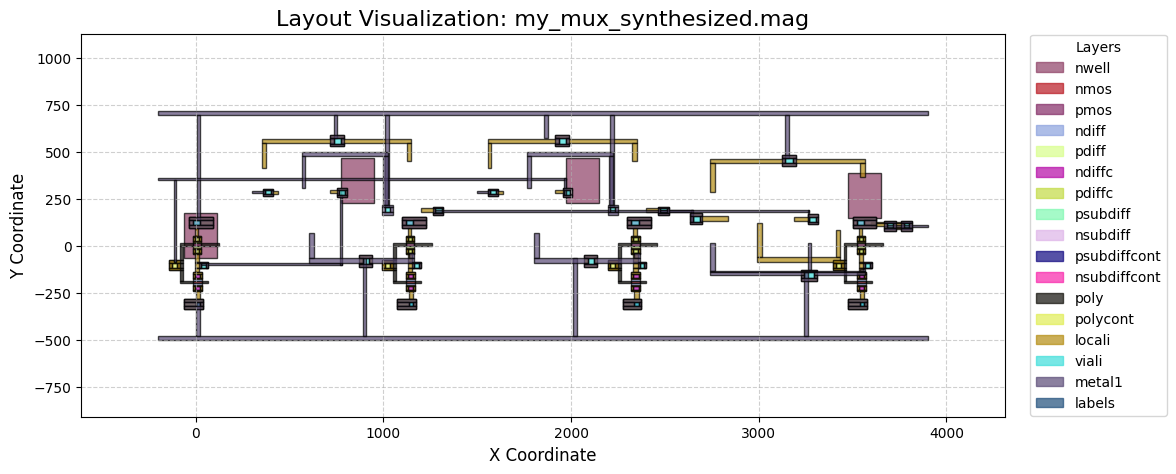

In [4]:
visualize_layout("generated_mag/my_mux_synthesized.mag")

In [5]:
# Define the generation query and the desired filename
query = "a NAND layout for sky130A tech named 'MY_NAND2'"
filename = "my_nand_gate2.mag"

# Generate the layout and save the file path
saved_file_path = layout_generator.generate_and_save(query, filename)

print(f"\nFile was generated at: {saved_file_path}")


💡 Generating layout for: 'a NAND layout for sky130A tech named 'MY_NAND2''
🤔 Planning necessary components...
✅ Plan complete. Needs components: ['2-input NAND gate']
🔍 Retrieving components from vector store...


/tmp/ipykernel_277034/984696862.py:111: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = self.retriever.get_relevant_documents(component, k=1)


✅ Retrieved 1 unique component layouts:
  - Component 1: 'and_common_3.mag'
🧠 Synthesizing final layout...


KeyboardInterrupt: 

In [6]:
import os
import glob
import re
import json
from dotenv import load_dotenv
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser, JsonOutputParser
from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAIEmbeddings
from langchain.vectorstores.faiss import FAISS
from langchain.docstore.document import Document
# Import the visualization function from your module
from mag_visualizer import visualize_layout

FAISS_INDEX_PATH = "faiss_mag_index"
GENERATED_MAG_DIR = "generated_mag"

class MagicLayoutGenerator:
    """
    An advanced RAG generator using a "Plan-and-Execute" strategy.
    It now supports hierarchical generation, creating all necessary sub-cell
    .mag files iteratively.
    """
    def __init__(self, mag_files_directory: str):
        print("🚀 Initializing Advanced MagicLayoutGenerator...")
        load_dotenv()
        api_key = os.getenv("GOOGLE_API_KEY")
        if not api_key: raise ValueError("🔴 GOOGLE_API_KEY not found.")

        self.llm = ChatGoogleGenerativeAI(model="gemini-2.5-pro", google_api_key=api_key, temperature=0.1)
        self.embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001", google_api_key=api_key)
        self._load_or_create_vector_store(mag_files_directory)

        # --- 1. The Planner Chain ---
        planner_prompt = PromptTemplate.from_template(
            """You are a digital logic planner. Based on the user's request, determine the fundamental logic gates required to build it.
            Respond with ONLY a JSON object containing a single key "components", which is a list of strings.
            For example, for 'a 2-input MUX', you would respond with {{"components": ["2-input AND gate", "inverter", "2-input OR gate"]}}.
            User Request: {query}"""
        )
        self.planner_chain = planner_prompt | self.llm | JsonOutputParser()

        # --- 2. The Synthesis Chain ---
        synthesis_prompt_template = """
You are an expert physical design engineer using the Magic VLSI tool. Your task is to create a new .mag layout for the requested cell.
-   **Analyze Goal**: Understand the user's 'QUESTION'.
-   **Use Context**: Review the provided 'CONTEXTS', which are .mag files for necessary components.
-   **Create Layout**: Generate the complete .mag content for the target cell. If you need to instance other cells (e.g., a NAND gate), use the 'use' command (e.g., 'use nand NAND_1'). Do not create rectangles for the instanced cell, only for the top-level routing and ports.
-   **Output**: The final output MUST BE ONLY the complete .mag file content, starting with 'magic' and ending with '<< end >>'.

CONTEXTS:
{context}

QUESTION:
{question}

ANSWER (Synthesized .mag File Content):
"""
        synthesis_prompt = PromptTemplate.from_template(synthesis_prompt_template)
        self.synthesis_chain = synthesis_prompt | self.llm | StrOutputParser()
        print("\n🎉 MagicLayoutGenerator initialized successfully!")

    def _preprocess_mag_file(self, file_path: str):
        with open(file_path, 'r') as f: content = f.read()
        match = re.search(r"#\s*THIS IS A?\s*(.*)", content, re.IGNORECASE)
        description = f"Magic layout file for {os.path.basename(file_path)}. "
        if match: description += f"The cell function is a {match.group(1).strip()}. "
        return Document(page_content=description + content, metadata={"source": file_path})

    def _load_or_create_vector_store(self, path: str):
        if os.path.exists(FAISS_INDEX_PATH):
            print(f"✅ Loading existing vector store from '{FAISS_INDEX_PATH}'...")
            self.vector_store = FAISS.load_local(FAISS_INDEX_PATH, self.embeddings, allow_dangerous_deserialization=True)
        else:
            print(f"🔍 Creating new vector store...")
            mag_files = glob.glob(os.path.join(path, '**', '*.mag'), recursive=True)
            if not mag_files: raise FileNotFoundError(f"🔴 No .mag files found in '{path}'.")
            documents = [self._preprocess_mag_file(file_path) for file_path in mag_files]
            self.vector_store = FAISS.from_documents(documents, self.embeddings)
            self.vector_store.save_local(FAISS_INDEX_PATH)
            print(f"✅ New vector store saved.")
        self.retriever = self.vector_store.as_retriever()

    def _parse_dependencies(self, mag_content: str) -> set:
        """Parses .mag content to find all 'use <cell_name>' dependencies."""
        dependencies = re.findall(r"^\s*use\s+([\w\d_]+)", mag_content, re.MULTILINE)
        return set(dependencies)

    def _generate_single_layout(self, query: str) -> str:
        """The core RAG pipeline for generating the content of one .mag file."""
        print(f"  - Planning for: '{query}'")
        plan = self.planner_chain.invoke({"query": query})
        components_to_find = plan.get("components", [])
        if not components_to_find:
            print(f"  🟡 Planner fallback for '{query}'.")
            components_to_find = [query]

        print(f"  - Retrieving base components...")
        retrieved_sources = set()
        all_retrieved_docs = []
        for component in components_to_find:
            docs = self.retriever.get_relevant_documents(component, k=1)
            for doc in docs:
                source_path = doc.metadata.get('source')
                if source_path not in retrieved_sources:
                    all_retrieved_docs.append(doc)
                    retrieved_sources.add(source_path)

        if not all_retrieved_docs:
            print(f"  🔴 Could not retrieve any base components for '{query}'.")
            return ""

        context_str = "".join(f"--- CONTEXT: {os.path.basename(doc.metadata.get('source', ''))} ---\n{doc.page_content}\n\n" for doc in all_retrieved_docs)
        
        print(f"  - Synthesizing: '{query}'")
        mag_content = self.synthesis_chain.invoke({"context": context_str, "question": query})
        return mag_content

    def generate_and_save(self, initial_query: str, top_level_filename: str):
        """
        Generates a hierarchical layout, creating all necessary sub-cell .mag files iteratively.
        """
        print(f"\n💡 Starting hierarchical generation for: '{initial_query}'")
        os.makedirs(GENERATED_MAG_DIR, exist_ok=True)

        top_level_cell_name = os.path.splitext(top_level_filename)[0]
        generation_queue = [(initial_query, top_level_cell_name)]
        completed_cells = set()
        all_saved_files = []

        while generation_queue:
            current_query, current_cell_name = generation_queue.pop(0)

            if current_cell_name in completed_cells:
                continue
            
            print(f"\n▶️ Generating cell: '{current_cell_name}' (Query: '{current_query}')")
            mag_content = self._generate_single_layout(current_query)

            if not mag_content:
                print(f"🔴 Failed to generate content for '{current_cell_name}'. Skipping.")
                continue
            
            file_path = os.path.join(GENERATED_MAG_DIR, f"{current_cell_name}.mag")
            with open(file_path, "w") as f: f.write(mag_content)
            print(f"✅ Layout saved to '{file_path}'")
            all_saved_files.append(file_path)
            completed_cells.add(current_cell_name)
            
            dependencies = self._parse_dependencies(mag_content)
            print(f"  - Dependencies found for '{current_cell_name}': {dependencies or 'None'}")
            
            for dep_cell_name in dependencies:
                if dep_cell_name not in completed_cells:
                    print(f"  - Adding dependency '{dep_cell_name}' to generation queue.")
                    dep_query = f"a {dep_cell_name.replace('_', ' ')} layout"
                    generation_queue.append((dep_query, dep_cell_name))

        print("\n🎉 Hierarchical generation complete.")
        top_level_path = os.path.join(GENERATED_MAG_DIR, top_level_filename)
        return all_saved_files, top_level_path


In [8]:
# Path to the directory containing your .mag files
MAG_FILES_PATH = '../std_cells_datasets/'

# Initialize the generator.
layout_generator = MagicLayoutGenerator(mag_files_directory=MAG_FILES_PATH)

🚀 Initializing Advanced MagicLayoutGenerator...
✅ Loading existing vector store from 'faiss_mag_index'...

🎉 MagicLayoutGenerator initialized successfully!


In [9]:
# Define the generation query and the desired filename
query = "a 2-input NAND layout for sky130A tech named 'MY_NAND2'"
filename = "my_nand_synthesized.mag"

# Generate the layout and all its dependencies
all_files, top_level_file = layout_generator.generate_and_save(query, filename)


💡 Starting hierarchical generation for: 'a 2-input NAND layout for sky130A tech named 'MY_NAND2''

▶️ Generating cell: 'my_nand_synthesized' (Query: 'a 2-input NAND layout for sky130A tech named 'MY_NAND2'')
  - Planning for: 'a 2-input NAND layout for sky130A tech named 'MY_NAND2''
  - Retrieving base components...
  - Synthesizing: 'a 2-input NAND layout for sky130A tech named 'MY_NAND2''
✅ Layout saved to 'generated_mag/my_nand_synthesized.mag'
  - Dependencies found for 'my_nand_synthesized': None

🎉 Hierarchical generation complete.



--- All Generated Files ---
  - generated_mag/my_nand_synthesized.mag

📊 Visualizing top-level layout...
📊 Visualizing layout from: generated_mag/my_nand_synthesized.mag


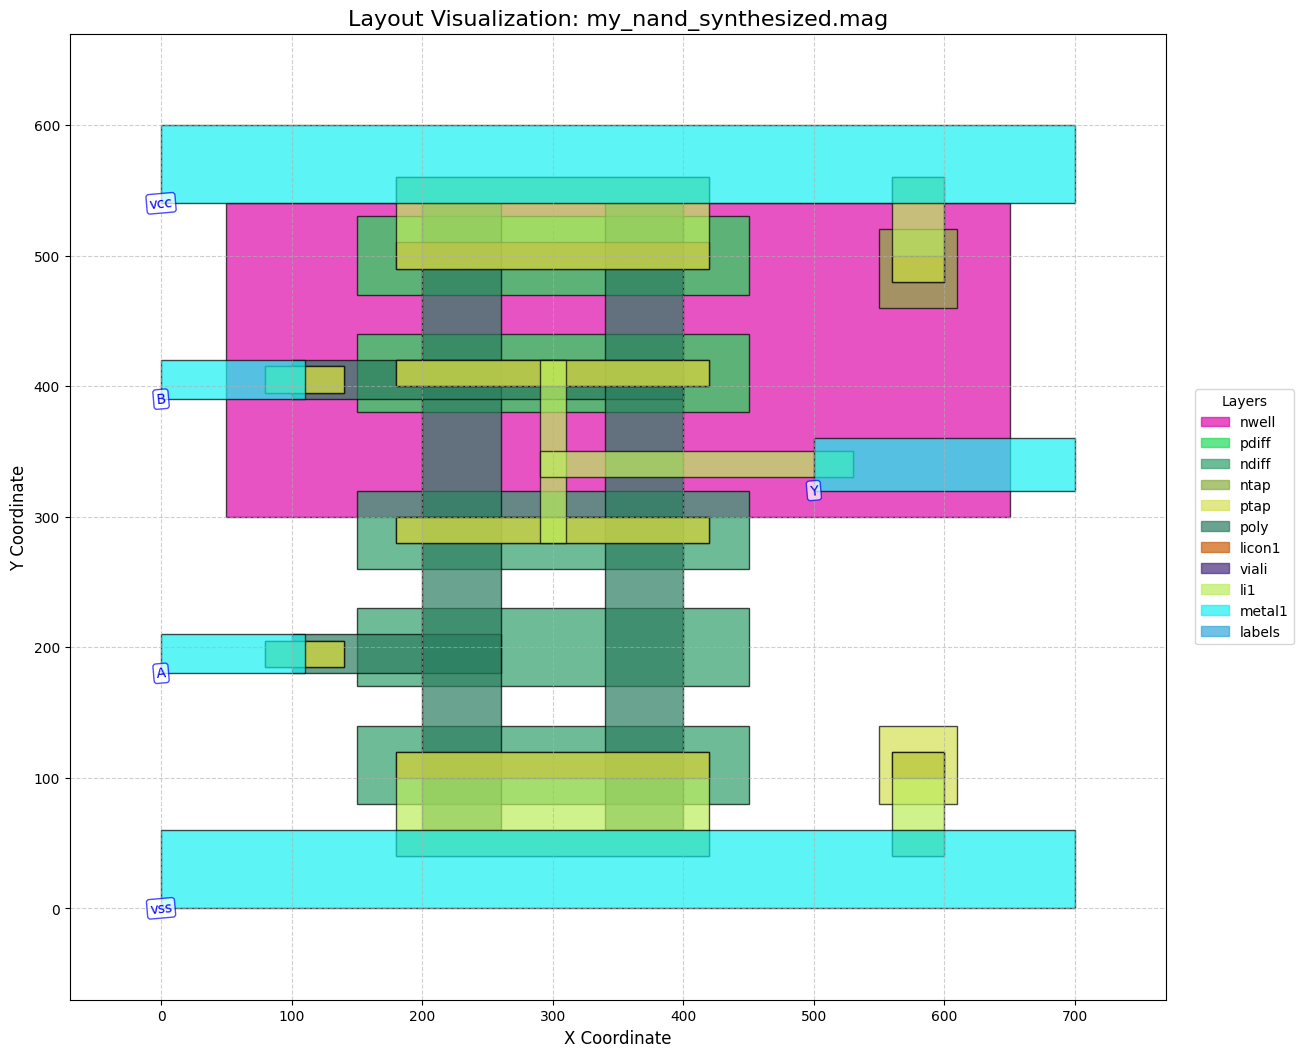

In [10]:
if all_files:
    print("\n--- All Generated Files ---")
    for f in sorted(all_files):
        print(f"  - {f}")
    
    print("\n📊 Visualizing top-level layout...")
    visualize_layout(top_level_file)
else:
    print("\n🔴 Layout generation failed.")

## LATEST (17:44 Jul 31)

In [22]:
import os
import glob
import re
import json
from dotenv import load_dotenv
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser, JsonOutputParser
from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAIEmbeddings
from langchain.vectorstores.faiss import FAISS
from langchain.docstore.document import Document
# Import the CORRECT visualization function that handles hierarchies
from mag_visualizer import visualize_layout

FAISS_INDEX_PATH = "faiss_mag_index"
GENERATED_MAG_DIR = "generated_mag"

class MagicLayoutGenerator:
    """
    An advanced RAG generator using a "Plan-and-Execute" strategy.
    It supports hierarchical generation, creating all necessary sub-cell
    .mag files iteratively.
    """
    def __init__(self, mag_files_directory: str):
        print("🚀 Initializing Advanced MagicLayoutGenerator...")
        load_dotenv()
        api_key = os.getenv("GOOGLE_API_KEY")
        if not api_key: raise ValueError("🔴 GOOGLE_API_KEY not found.")

        self.llm = ChatGoogleGenerativeAI(model="gemini-2.5-pro", google_api_key=api_key, temperature=0.1)
        self.embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001", google_api_key=api_key)
        self._load_or_create_vector_store(mag_files_directory)

        # --- 1. The Planner Chain ---
        planner_prompt = PromptTemplate.from_template(
            """You are a digital logic planner. Based on the user's request, determine the fundamental logic gates required to build it.
            Respond with ONLY a JSON object containing a single key "components", which is a list of strings.
            For 'a 2-input MUX', you would respond with {{"components": ["2-input AND gate", "inverter", "2-input OR gate"]}}.
            User Request: {query}"""
        )
        self.planner_chain = planner_prompt | self.llm | JsonOutputParser()

        # --- 2. The Synthesis Chain ---
        synthesis_prompt_template = """
You are an expert physical design engineer using the Magic VLSI tool. Your task is to create a new .mag layout for the requested cell.
-   **Analyze Goal**: Understand the user's 'QUESTION'.
-   **Use Context**: Review the provided 'CONTEXTS', which are .mag files for necessary components.
-   **Create Layout**: Generate the complete .mag content for the target cell. If you need to instance other cells (e.g., a NAND gate), use the 'use' command (e.g., 'use nand NAND_1'). Do not create rectangles for the instanced cell, only for the top-level routing and ports.
-   **Output**: The final output MUST BE ONLY the complete .mag file content, starting with 'magic' and ending with '<< end >>'.

CONTEXTS:
{context}

QUESTION:
{question}

ANSWER (Synthesized .mag File Content):
"""
        synthesis_prompt = PromptTemplate.from_template(synthesis_prompt_template)
        self.synthesis_chain = synthesis_prompt | self.llm | StrOutputParser()
        print("\n🎉 MagicLayoutGenerator initialized successfully!")

    def _preprocess_mag_file(self, file_path: str):
        with open(file_path, 'r') as f: content = f.read()
        match = re.search(r"#\s*THIS IS?\s*(.*)", content, re.IGNORECASE)
        description = f"Magic layout file for {os.path.basename(file_path)}. "
        if match: description += f"The cell function is a {match.group(1).strip()}. "
        return Document(page_content=description + content, metadata={"source": file_path})

    def _load_or_create_vector_store(self, path: str):
        if os.path.exists(FAISS_INDEX_PATH):
            print(f"✅ Loading existing vector store from '{FAISS_INDEX_PATH}'...")
            self.vector_store = FAISS.load_local(FAISS_INDEX_PATH, self.embeddings, allow_dangerous_deserialization=True)
        else:
            print(f"🔍 Creating new vector store...")
            mag_files = glob.glob(os.path.join(path, '**', '*.mag'), recursive=True)
            if not mag_files: raise FileNotFoundError(f"🔴 No .mag files found in '{path}'.")
            documents = [self._preprocess_mag_file(file_path) for file_path in mag_files]
            self.vector_store = FAISS.from_documents(documents, self.embeddings)
            self.vector_store.save_local(FAISS_INDEX_PATH)
            print(f"✅ New vector store saved.")
        self.retriever = self.vector_store.as_retriever()

    def _parse_dependencies(self, mag_content: str) -> set:
        """Parses .mag content to find all 'use <cell_name>' dependencies."""
        dependencies = re.findall(r"^\s*use\s+([\w\d_]+)", mag_content, re.MULTILINE)
        return set(dependencies)

    def _generate_single_layout(self, query: str) -> str:
        """The core RAG pipeline for generating the content of one .mag file."""
        print(f"  - Planning for: '{query}'")
        plan = self.planner_chain.invoke({"query": query})
        components_to_find = plan.get("components", [])
        if not components_to_find:
            print(f"  🟡 Planner fallback for '{query}'.")
            components_to_find = [query]

        retrieved_sources = set()
        all_retrieved_docs = []
        for component in components_to_find:
            docs = self.retriever.get_relevant_documents(component, k=1)
            for doc in docs:
                source_path = doc.metadata.get('source')
                if source_path not in retrieved_sources:
                    all_retrieved_docs.append(doc)
                    retrieved_sources.add(source_path)

        if not all_retrieved_docs:
            print(f"  🔴 Could not retrieve any base components for '{query}'.")
            return ""

        # Print the retrieved contexts as requested
        print(f"  ✅ Retrieved {len(all_retrieved_docs)} contexts for synthesizing '{query}':")
        context_str = ""
        for i, doc in enumerate(all_retrieved_docs):
            source_file = os.path.basename(doc.metadata.get('source', 'Unknown'))
            print(f"    - Context {i+1}: '{source_file}'")
            context_str += f"--- CONTEXT: {source_file} ---\n{doc.page_content}\n\n"
        
        print(f"  - Synthesizing: '{query}'")
        mag_content = self.synthesis_chain.invoke({"context": context_str, "question": query})
        return mag_content

    def generate_and_save(self, initial_query: str, top_level_filename: str):
        """
        Generates a hierarchical layout, creating all necessary sub-cell .mag files iteratively.
        """
        print(f"\n💡 Starting hierarchical generation for: '{initial_query}'")
        os.makedirs(GENERATED_MAG_DIR, exist_ok=True)

        top_level_cell_name = os.path.splitext(top_level_filename)[0]
        generation_queue = [(initial_query, top_level_cell_name)]
        completed_cells = set()
        all_saved_files = []

        while generation_queue:
            current_query, current_cell_name = generation_queue.pop(0)

            if current_cell_name in completed_cells: continue
            
            print(f"\n▶️ Generating cell: '{current_cell_name}' (Query: '{current_query}')")
            mag_content = self._generate_single_layout(current_query)

            if not mag_content:
                print(f"🔴 Failed to generate content for '{current_cell_name}'. Skipping.")
                continue
            
            file_path = os.path.join(GENERATED_MAG_DIR, f"{current_cell_name}.mag")
            with open(file_path, "w") as f: f.write(mag_content)
            print(f"✅ Layout saved to '{file_path}'")
            all_saved_files.append(file_path)
            completed_cells.add(current_cell_name)
            
            dependencies = self._parse_dependencies(mag_content)
            print(f"  - Dependencies found for '{current_cell_name}': {dependencies or 'None'}")
            
            for dep_cell_name in dependencies:
                if dep_cell_name not in completed_cells:
                    print(f"  - Adding dependency '{dep_cell_name}' to generation queue.")
                    dep_query = f"a {dep_cell_name.replace('_', ' ')} layout"
                    generation_queue.append((dep_query, dep_cell_name))

        print("\n🎉 Hierarchical generation complete.")
        top_level_path = os.path.join(GENERATED_MAG_DIR, top_level_filename)
        return all_saved_files, top_level_path

In [23]:
MAG_FILES_PATH = '../std_cells_datasets/'
layout_generator = MagicLayoutGenerator(mag_files_directory=MAG_FILES_PATH)

🚀 Initializing Advanced MagicLayoutGenerator...
🔍 Creating new vector store...
✅ New vector store saved.

🎉 MagicLayoutGenerator initialized successfully!


In [20]:
# Define the generation query and the desired filename
query = "an INVERTER gate layout for sky130A tech named 'MY_INV'"
filename = "my_inv_2.mag"
# Generate the layout and all its dependencies
all_files, top_level_file = layout_generator.generate_and_save(query, filename)


💡 Starting hierarchical generation for: 'an INVERTER gate layout for sky130A tech named 'MY_INV''

▶️ Generating cell: 'my_inv_2' (Query: 'an INVERTER gate layout for sky130A tech named 'MY_INV'')
  - Planning for: 'an INVERTER gate layout for sky130A tech named 'MY_INV''
  ✅ Retrieved 1 contexts for synthesizing 'an INVERTER gate layout for sky130A tech named 'MY_INV'':
    - Context 1: 'inverter_common.mag'
  - Synthesizing: 'an INVERTER gate layout for sky130A tech named 'MY_INV''


KeyboardInterrupt: 


--- All Generated Files ---
  - generated_mag/my_inv_1.mag

📊 Visualizing top-level layout: generated_mag/my_inv_1.mag
📊 Visualizing layout from: generated_mag/my_inv_1.mag


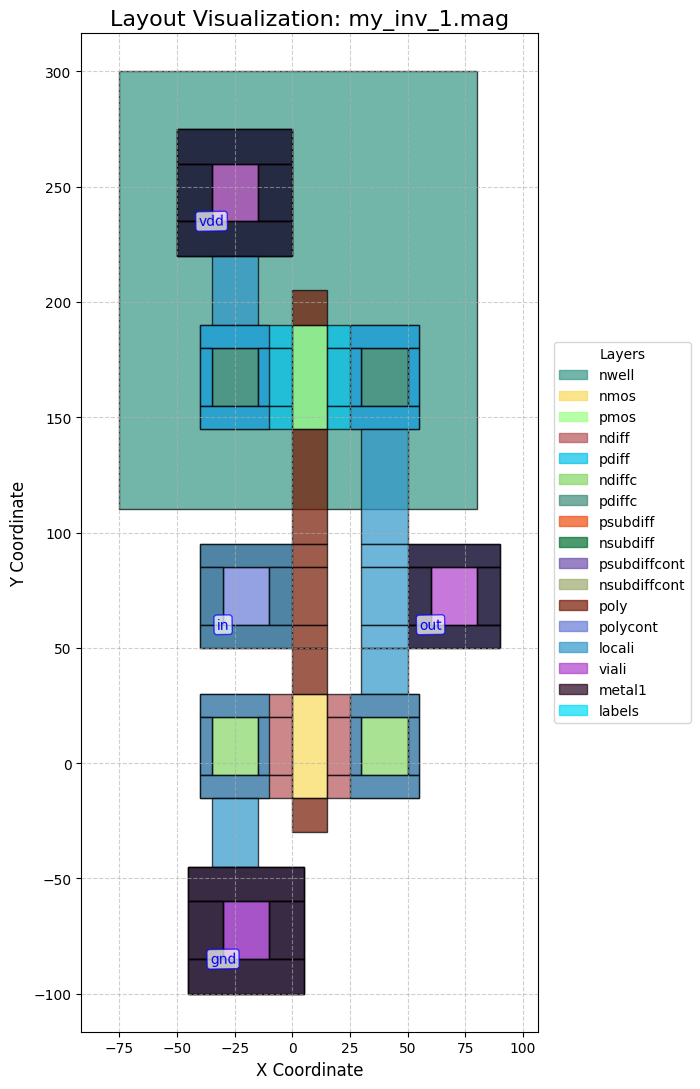

In [13]:
if all_files:
    print("\n--- All Generated Files ---")
    for f in sorted(all_files):
        print(f"  - {f}")
    
    print(f"\n📊 Visualizing top-level layout: {top_level_file}")
    visualize_layout(top_level_file)
else:
    print("\n🔴 Layout generation failed.")

📊 Visualizing layout from: ../std_cells_datasets/inverter_common.mag


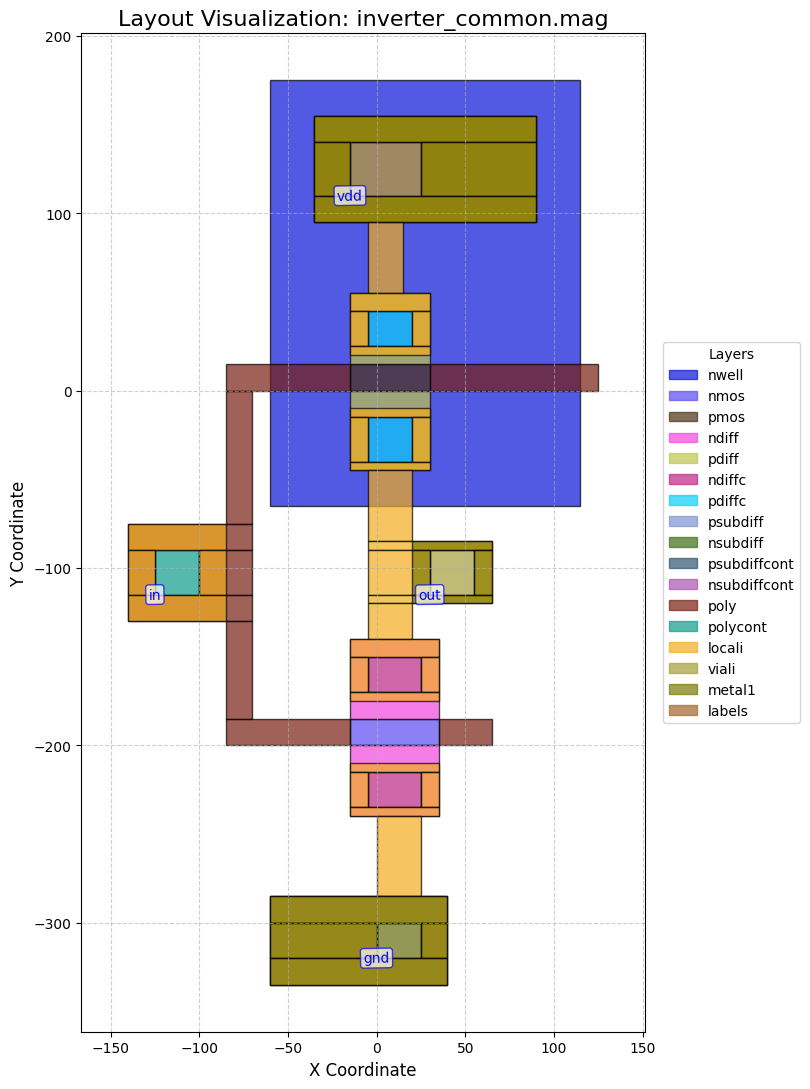

In [15]:
visualize_layout("../std_cells_datasets/inverter_common.mag")

In [24]:
# Define the generation query and the desired filename
query = "an NAND gate layout for sky130A tech named 'MY_NAND'"
filename = "my_nand_1.mag"
# Generate the layout and all its dependencies
all_files, top_level_file = layout_generator.generate_and_save(query, filename)


💡 Starting hierarchical generation for: 'an NAND gate layout for sky130A tech named 'MY_NAND''

▶️ Generating cell: 'my_nand_1' (Query: 'an NAND gate layout for sky130A tech named 'MY_NAND'')
  - Planning for: 'an NAND gate layout for sky130A tech named 'MY_NAND''
  ✅ Retrieved 1 contexts for synthesizing 'an NAND gate layout for sky130A tech named 'MY_NAND'':
    - Context 1: 'and_common_3.mag'
  - Synthesizing: 'an NAND gate layout for sky130A tech named 'MY_NAND''


KeyboardInterrupt: 

In [ ]:
if all_files:
    print("\n--- All Generated Files ---")
    for f in sorted(all_files):
        print(f"  - {f}")
    
    print(f"\n📊 Visualizing top-level layout: {top_level_file}")
    visualize_layout(top_level_file)
else:
    print("\n🔴 Layout generation failed.")

In [31]:
import os
import glob
import re
import shutil
from dotenv import load_dotenv
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAIEmbeddings
from langchain.vectorstores.faiss import FAISS
from langchain.docstore.document import Document
# Import the CORRECT visualizer that can handle hierarchical designs
from mag_visualizer import visualize_layout

FAISS_INDEX_PATH = "faiss_mag_index"
GENERATED_MAG_DIR = "generated_mag"

class MagicLayoutGenerator:
    """
    A robust RAG generator using targeted preprocessing and hierarchical generation.
    """
    def __init__(self, mag_files_directory: str):
        print("🚀 Initializing MagicLayoutGenerator...")
        load_dotenv()
        api_key = os.getenv("GOOGLE_API_KEY")
        if not api_key: raise ValueError("🔴 GOOGLE_API_KEY not found.")

        self.llm = ChatGoogleGenerativeAI(model="gemini-2.5-pro", google_api_key=api_key, temperature=0.0)
        self.embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001", google_api_key=api_key)
        self._load_or_create_vector_store(mag_files_directory)

        # A robust prompt that instructs the LLM how to use contexts
        synthesis_prompt_template = """
You are a Magic VLSI layout expert. Your task is to generate a .mag file based on the user's QUESTION.

**CRITICAL INSTRUCTIONS:**
1.  **Analyze CONTEXTS**: You will be given up to 3 contexts. First, identify the SINGLE most relevant context. The best context has a filename that most closely matches the QUESTION (e.g., for a 'NAND gate' query, the 'nand.mag' context is best).
2.  **Prioritize the Best Context**:
    - If the QUESTION asks for a simple gate, you MUST base your answer almost entirely on that single best context. Replicate its geometry and rename its labels.
    - If the QUESTION asks for a complex cell (like a MUX), you MUST use the provided component contexts to build the new layout by instantiating them with the 'use' command and adding routing.
3.  **DO NOT SIMPLIFY**: You are forbidden from simplifying the provided contexts.
4.  **OUTPUT FORMAT**: Your response MUST BE ONLY the raw .mag file content, starting with 'magic' and ending with '<< end >>'.

CONTEXTS:
{context}

QUESTION:
{question}

ANSWER (A complete .mag file, based on the most relevant context):
"""
        synthesis_prompt = PromptTemplate.from_template(synthesis_prompt_template)
        self.synthesis_chain = synthesis_prompt | self.llm | StrOutputParser()
        print("\n🎉 MagicLayoutGenerator initialized successfully!")

    def _preprocess_mag_file(self, file_path: str):
        """
        Creates a heavily weighted document description for precise retrieval.
        """
        with open(file_path, 'r') as f: content = f.read()
        
        cell_name = os.path.splitext(os.path.basename(file_path))[0]
        # Aggressively repeat keywords to boost their importance in the vector embedding.
        keyword_part = f"cell name is {cell_name}. function is {cell_name}. " * 5
        description = f"Magic layout for standard cell. {keyword_part}"
        
        match = re.search(r"#\s*this is\s+(.*)", content, re.IGNORECASE)
        if match:
            description += f"It is described as a {match.group(1).strip()}. "
        
        return Document(page_content=description + content, metadata={"source": file_path})

    def _load_or_create_vector_store(self, path: str):
        if os.path.exists(FAISS_INDEX_PATH):
            print(f"✅ Loading existing vector store from '{FAISS_INDEX_PATH}'...")
            self.vector_store = FAISS.load_local(FAISS_INDEX_PATH, self.embeddings, allow_dangerous_deserialization=True)
        else:
            print(f"🔍 Creating new vector store with preprocessing...")
            mag_files = glob.glob(os.path.join(path, '**', '*.mag'), recursive=True)
            if not mag_files: raise FileNotFoundError(f"🔴 No .mag files found in '{path}'.")
            documents = [self._preprocess_mag_file(file_path) for file_path in mag_files]
            self.vector_store = FAISS.from_documents(documents, self.embeddings)
            self.vector_store.save_local(FAISS_INDEX_PATH)
            print(f"✅ New vector store saved to '{FAISS_INDEX_PATH}'.")
        self.retriever = self.vector_store.as_retriever(search_kwargs={"k": 3})

    def _parse_dependencies(self, mag_content: str) -> set:
        dependencies = re.findall(r"^\s*use\s+([\w\d_]+)", mag_content, re.MULTILINE)
        return set(dependencies)

    def generate_and_save(self, initial_query: str, top_level_filename: str):
        """
        Generates a hierarchical layout by retrieving contexts for each required cell.
        """
        print(f"\n💡 Starting hierarchical generation for: '{initial_query}'")
        os.makedirs(GENERATED_MAG_DIR, exist_ok=True)

        top_level_cell_name = os.path.splitext(top_level_filename)[0]
        generation_queue = [(initial_query, top_level_cell_name)]
        completed_cells = set()
        all_saved_files = []

        while generation_queue:
            current_query, current_cell_name = generation_queue.pop(0)

            if current_cell_name in completed_cells: continue
            
            print(f"\n▶️ Generating cell: '{current_cell_name}' (Query: '{current_query}')")
            
            retrieved_docs = self.retriever.get_relevant_documents(current_query)
            if not retrieved_docs:
                print(f"🔴 Could not retrieve any context for '{current_query}'. Skipping.")
                continue

            print(f"  ✅ Retrieved {len(retrieved_docs)} contexts for synthesis:")
            context_str = ""
            for i, doc in enumerate(retrieved_docs):
                source_file = os.path.basename(doc.metadata.get('source', 'Unknown'))
                print(f"    - Context {i+1}: '{source_file}'")
                context_str += f"--- CONTEXT {i+1}: {source_file} ---\n{doc.page_content}\n\n"
            
            print(f"  - Synthesizing '{current_cell_name}'...")
            mag_content = self.synthesis_chain.invoke({"context": context_str, "question": current_query})

            if not mag_content or not mag_content.strip().startswith("magic"):
                print(f"🔴 Synthesis failed for '{current_cell_name}'. Skipping.")
                continue

            file_path = os.path.join(GENERATED_MAG_DIR, f"{current_cell_name}.mag")
            with open(file_path, "w") as f: f.write(mag_content)
            print(f"✅ Layout saved to '{file_path}'")
            all_saved_files.append(file_path)
            completed_cells.add(current_cell_name)
            
            dependencies = self._parse_dependencies(mag_content)
            if dependencies: print(f"  - Dependencies found: {dependencies}")
            
            for dep_cell_name in dependencies:
                if dep_cell_name not in completed_cells:
                    generation_queue.append((f"a {dep_cell_name.replace('_', ' ')} layout", dep_cell_name))

        print("\n🎉 Hierarchical generation complete.")
        top_level_path = os.path.join(GENERATED_MAG_DIR, top_level_filename)
        return all_saved_files, top_level_path


In [33]:
MAG_FILES_PATH = '../std_cells_datasets/'
layout_generator = MagicLayoutGenerator(mag_files_directory=MAG_FILES_PATH)

🚀 Initializing MagicLayoutGenerator...
✅ Loading existing vector store from 'faiss_mag_index'...

🎉 MagicLayoutGenerator initialized successfully!


In [34]:
# --- Main Execution ---
if __name__ == "__main__":

    # --- Example 1: Generate a simple gate ---
    print("\n" + "="*50)
    print("Running Example 1: Simple Gate (NAND)")
    print("="*50)
    query_simple = "a 2-input NAND gate layout named 'MY_NAND2'"
    filename_simple = "my_nand_gate.mag"
    all_files_simple, top_level_simple = layout_generator.generate_and_save(query_simple, filename_simple)


Running Example 1: Simple Gate (NAND)

💡 Starting hierarchical generation for: 'a 2-input NAND gate layout named 'MY_NAND2''

▶️ Generating cell: 'my_nand_gate' (Query: 'a 2-input NAND gate layout named 'MY_NAND2'')
  ✅ Retrieved 3 contexts for synthesis:
    - Context 1: 'and_common_3.mag'
    - Context 2: 'or_common_3.mag'
    - Context 3: 'and_1.mag'
  - Synthesizing 'my_nand_gate'...
✅ Layout saved to 'generated_mag/my_nand_gate.mag'

🎉 Hierarchical generation complete.


📊 Visualizing layout from: generated_mag/my_nand_gate.mag


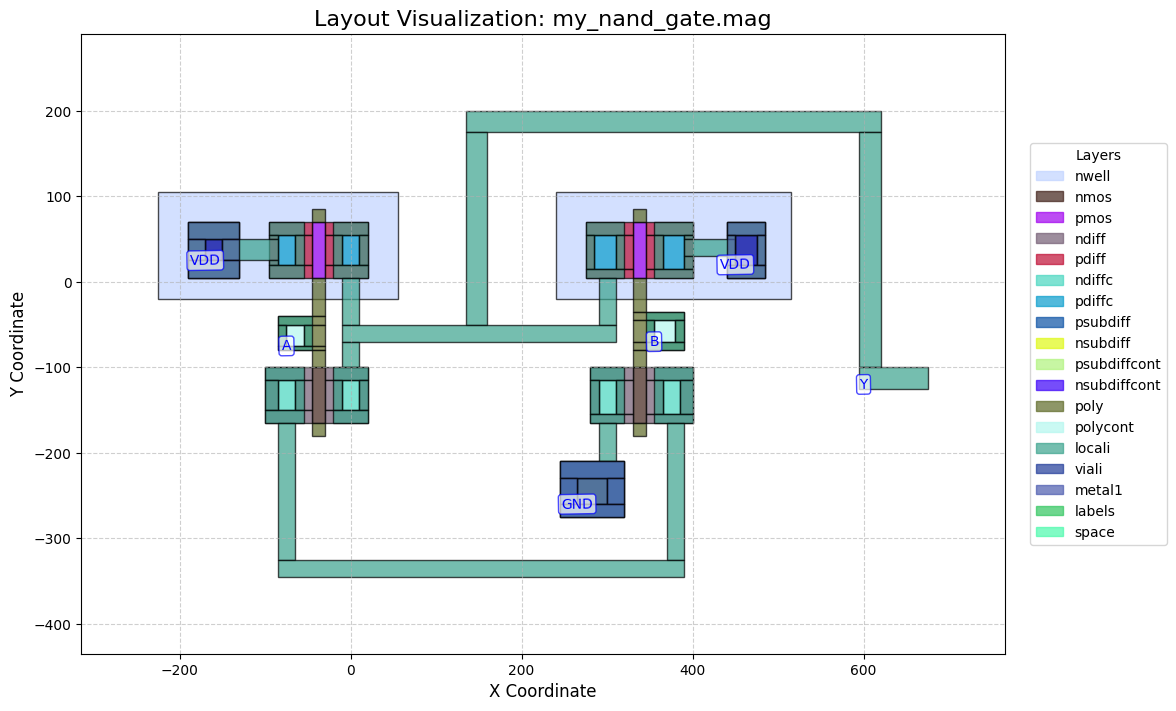

In [35]:
if top_level_simple and os.path.exists(top_level_simple):
        visualize_layout(top_level_simple)

In [36]:
# --- Example 2: Generate a complex, hierarchical gate ---
print("\n" + "="*50)
print("Running Example 2: Complex Gate (AND)")
print("="*50)
query_complex = "a 2-input (AND)"
filename_complex = "my_and.mag"
all_files_complex, top_level_complex = layout_generator.generate_and_save(query_complex, filename_complex)


Running Example 2: Complex Gate (AND)

💡 Starting hierarchical generation for: 'a 2-input (AND)'

▶️ Generating cell: 'my_and' (Query: 'a 2-input (AND)')
  ✅ Retrieved 3 contexts for synthesis:
    - Context 1: 'and_common_3.mag'
    - Context 2: 'and_1.mag'
    - Context 3: 'or.mag'
  - Synthesizing 'my_and'...
✅ Layout saved to 'generated_mag/my_and.mag'
  - Dependencies found: {'inv2'}

▶️ Generating cell: 'inv2' (Query: 'a inv2 layout')
  ✅ Retrieved 3 contexts for synthesis:
    - Context 1: 'or_common_2_tb.mag'
    - Context 2: 'inv2.mag'
    - Context 3: 'and_common_3.mag'
  - Synthesizing 'inv2'...
✅ Layout saved to 'generated_mag/inv2.mag'

🎉 Hierarchical generation complete.


📊 Visualizing layout from: generated_mag/my_and.mag


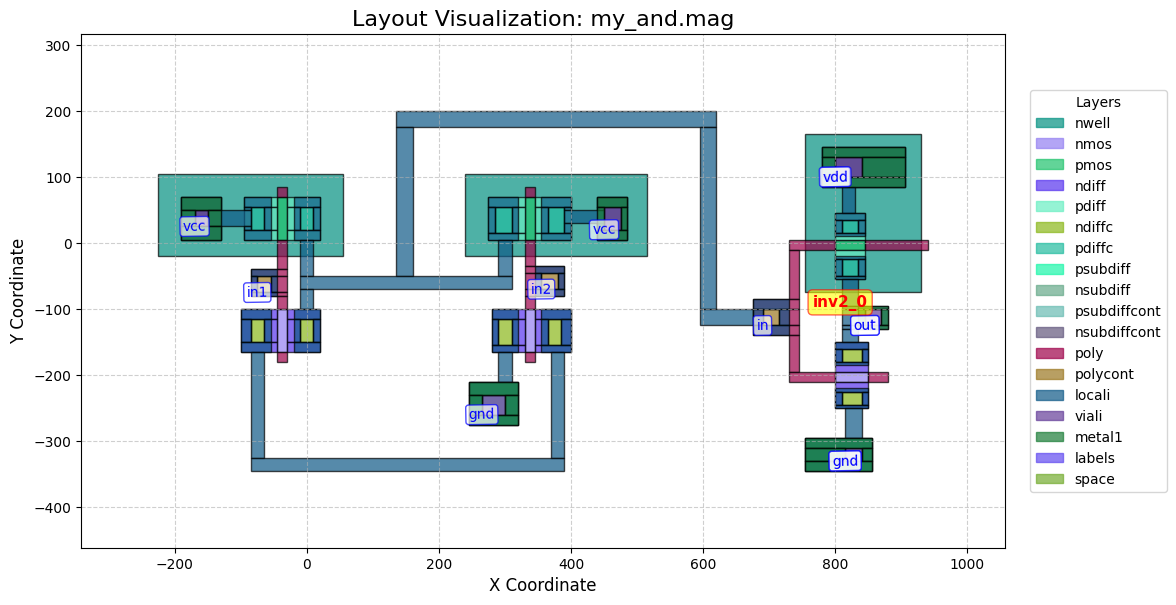

In [37]:
if top_level_complex and os.path.exists(top_level_complex):
    visualize_layout(top_level_complex)

In [38]:
# --- Main Execution ---
if __name__ == "__main__":

    # --- Example 1: Generate a simple gate ---
    print("\n" + "="*50)
    print("Running Example 3: Simple Gate (Inverter)")
    print("="*50)
    query_simple = "an INVERTER gate layout named 'MY_INV'"
    filename_simple = "my_inv_gate.mag"
    all_files_simple, top_level_simple = layout_generator.generate_and_save(query_simple, filename_simple)


Running Example 3: Simple Gate (Inverter)

💡 Starting hierarchical generation for: 'an INVERTER gate layout named 'MY_INV''

▶️ Generating cell: 'my_inv_gate' (Query: 'an INVERTER gate layout named 'MY_INV'')
  ✅ Retrieved 3 contexts for synthesis:
    - Context 1: 'inv2.mag'
    - Context 2: 'inverter.mag'
    - Context 3: 'inverter_common.mag'
  - Synthesizing 'my_inv_gate'...
✅ Layout saved to 'generated_mag/my_inv_gate.mag'

🎉 Hierarchical generation complete.


📊 Visualizing layout from: ../std_cells_codes/generated_mag/my_inv_gate.mag


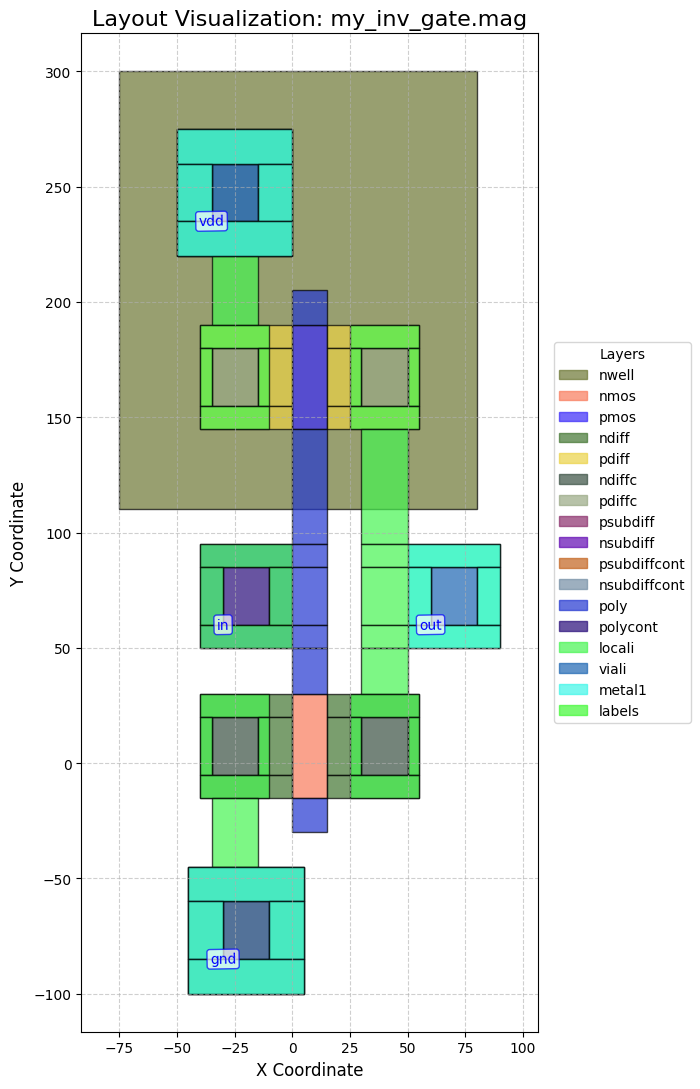

In [42]:
visualize_layout("../std_cells_codes/generated_mag/my_inv_gate.mag")

📊 Visualizing layout from: ../std_cells_codes/generated_mag_st/my_inv1.mag


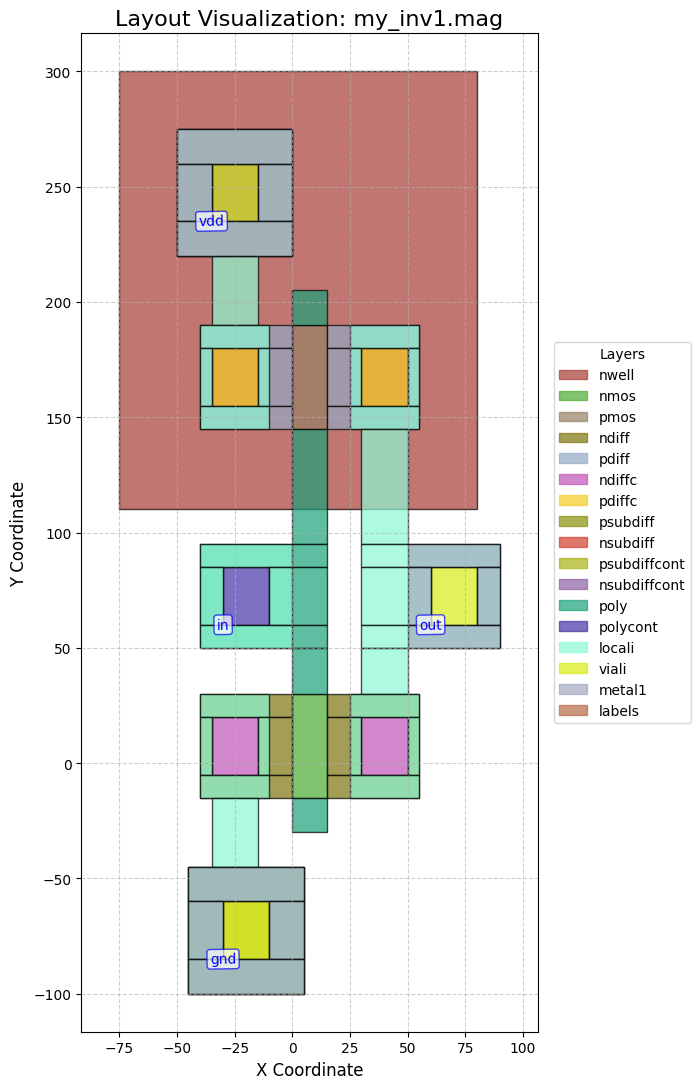

In [46]:
visualize_layout("../std_cells_codes/generated_mag_st/my_inv1.mag")

📊 Visualizing layout from: ../std_cells_codes/generated_mag_st/my_mux1.mag


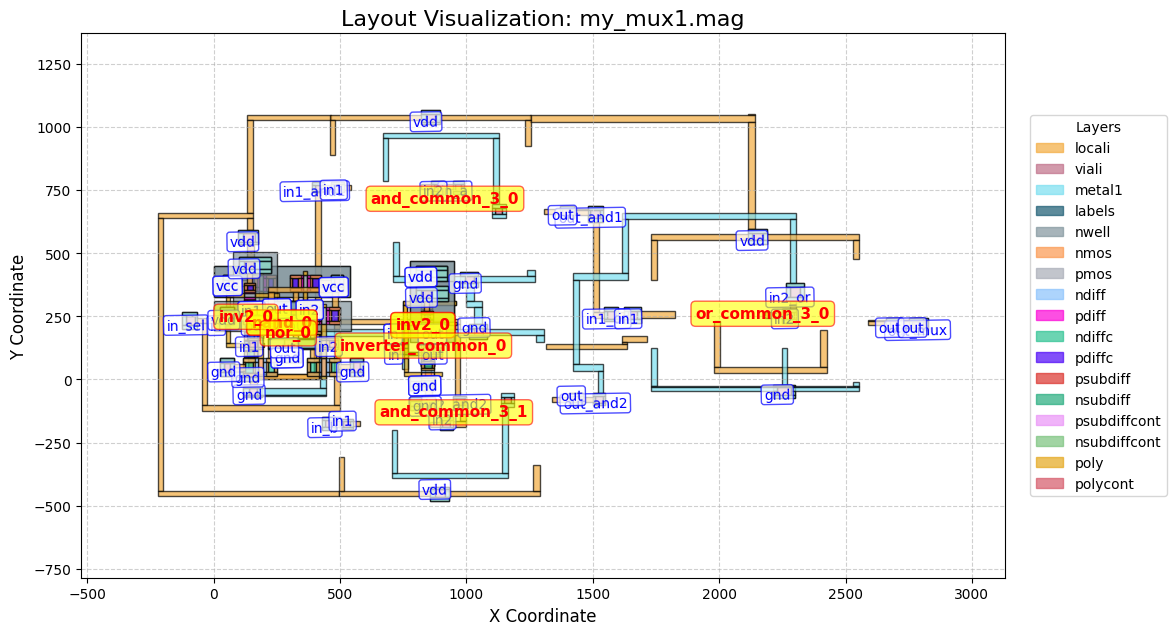

In [47]:
visualize_layout("../std_cells_codes/generated_mag_st/my_mux1.mag")